In [1]:
import sklearn
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D,
                                     Flatten, Dropout, BatchNormalization, Activation)

### The american sign language contains 26 letters, but the dataset contains only 24 different classes. This is due to the fact that the signs related to the J and Z letters require movement, so they can't be represented through static images.  

### El lenguaje de señas americano consta de 26 símbolos, pero la base de datos de la plataforma contiene 24, esto se debe a que los símbolos referentes a la J y a la Z requieren movimiento, por lo que no se pueden representar mediante imágenes estáticas.

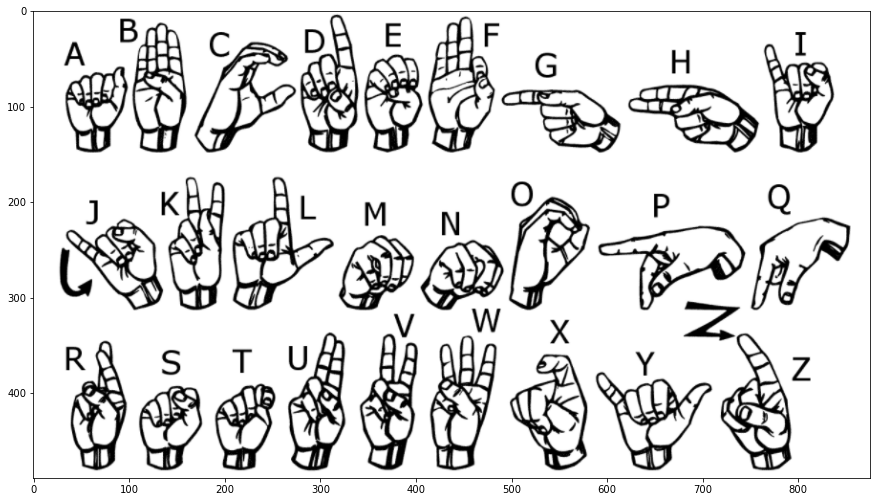

In [4]:
img = mpimg.imread("../Datos/american_sign_language.PNG")
plt.figure(figsize = (15, 12))
plt.imshow(img)

### The labels are the value of the position in which each letter is found in the alphabet (starting from 0). I will relate each letter to its index in order to reference the images.

### Las etiquetas son el valor de la posición en la que se encuentra cada letra en el abecedario (empezando desde 0). Voy a relacionar cada letra con su índice para poder referenciar las imágenes.

In [5]:
sig_labels = {}
letras = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range (26):
    sig_labels[i] = letras[i]

### The platform has separate training and test sets, so I will use that distribution and refrain from evaluating the model on the test set until it is complete.

### La plataforma tiene separados los conjuntos de entrenamiento y prueba, por lo que utilizaré esa distribución, sin evaluar el modelo en el conjunto de prueba hasta que esté completado.

In [6]:
train_val_set = pd.read_csv("../Datos/sign_mnist_train.csv")

train_val_y_df = train_val_set["label"]
train_val_X_df = train_val_set.drop("label", axis = "columns")

train_val_y = train_val_y_df.to_numpy()
train_val_X = train_val_X_df.to_numpy()

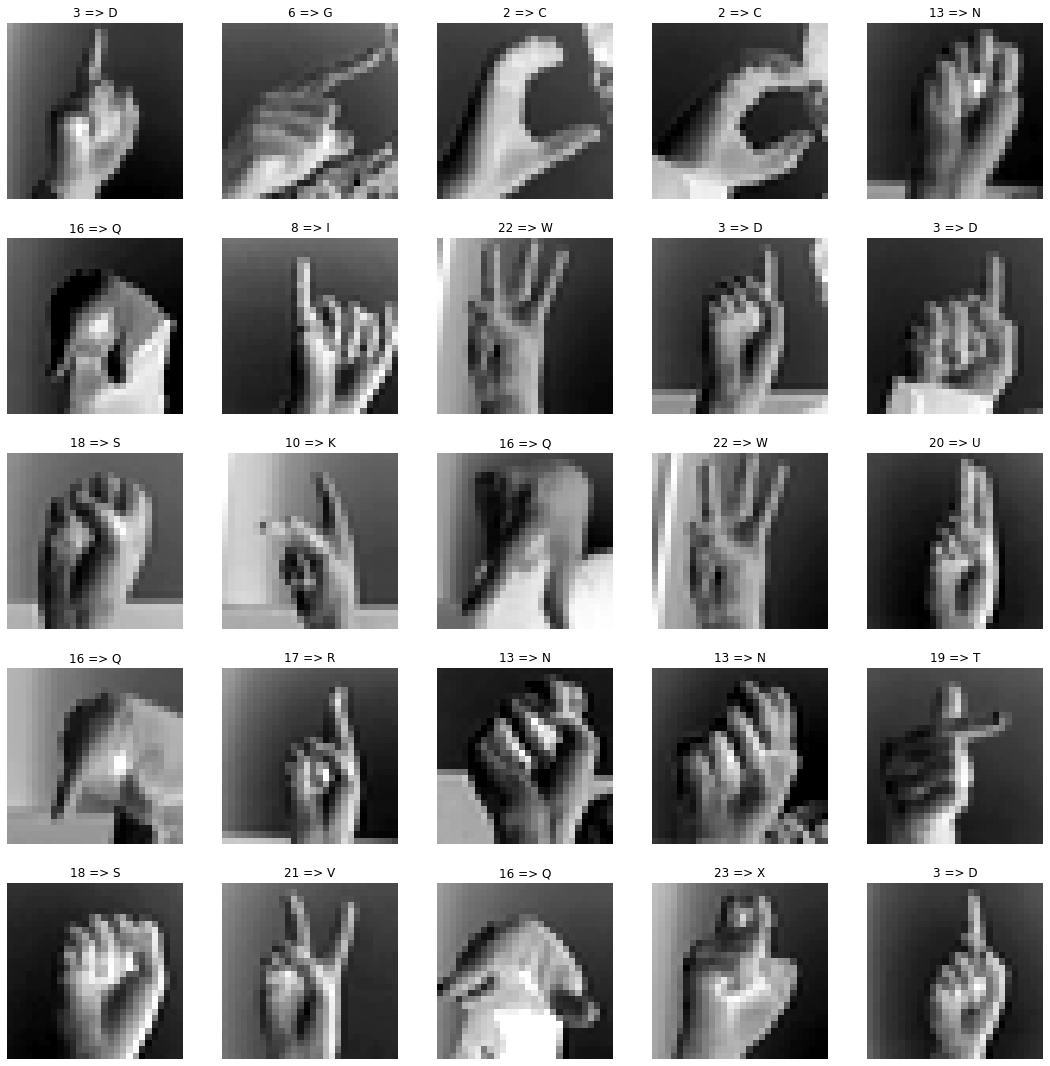

In [7]:
examples25 = train_val_X[0 : 25]

figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0 # row
contc = 0 # column
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(examples25[i].reshape(28, 28), cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(train_val_y[i], sig_labels[train_val_y[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

#### It is important for the images to be shuffled (not arranged in alphabetical order, such as all A first, then B, etc.) as some models are sensitive to the order of elements and can produce poor results if they are not properly shuffled. Analyzing the first 25 samples, we can see that they are already shuffled.

#### It is important for the images to be shuffled (not arranged in alphabetical order, such as all A first, then B, etc.) as some models are sensitive to the order of elements and can produce poor results if they are not properly shuffled. Analyzing the first 25 samples, we can see that they are already shuffled.

#### I am going to triple the size of the training and validation sets using artificial data extension.

#### Voy a utilizar la extensión artificial para triplicar el tamaño del conjunto de entrenamiento y validación.

In [8]:
train_val_X_for_extension = train_val_X.reshape(27455, 28, 28, 1).copy()

In [9]:
datagen1 = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = 0.1)
X_new_1_raw = datagen1.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

datagen2 = ImageDataGenerator(rotation_range = 20)
X_new_2_raw = datagen2.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

In [10]:
X_new_1 = X_new_1_raw[0].copy()
X_new_2 = X_new_2_raw[0].copy()

In [11]:
X_train_val_extended = np.concatenate((train_val_X_for_extension, X_new_1, X_new_2), axis = 0)
y_train_val_extended = np.concatenate((train_val_y, train_val_y, train_val_y))

In [12]:
X_train_val_extended.shape, y_train_val_extended.shape

((82365, 28, 28, 1), (82365,))

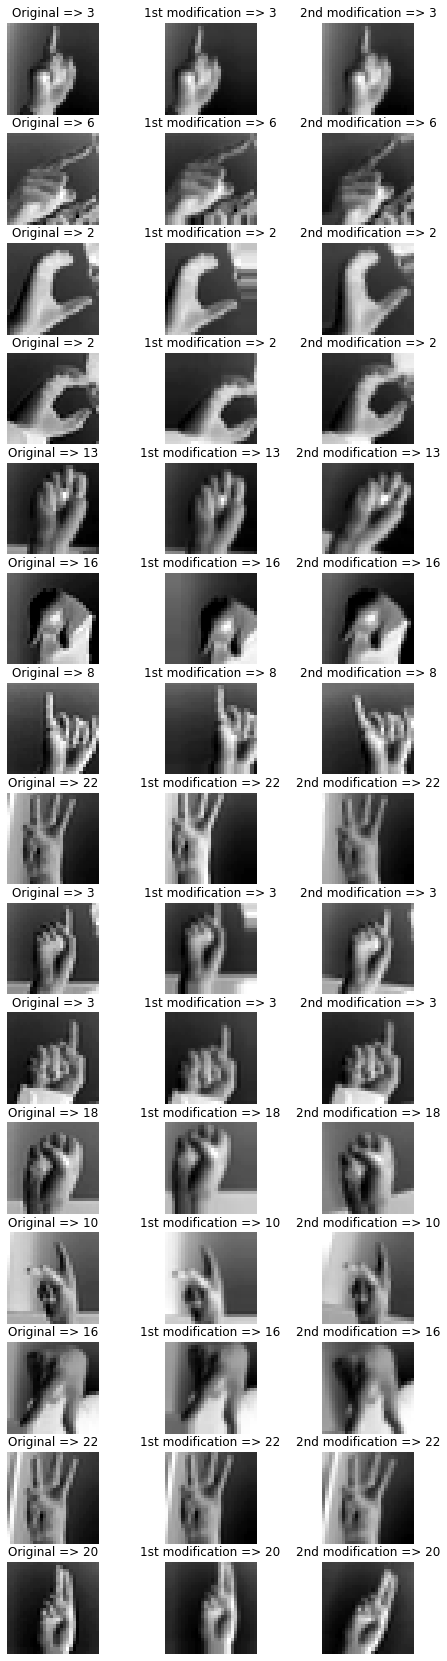

In [13]:
figs, axs = plt.subplots(15, 3, figsize = (8, 30))
contf = 0
contc = 0

for i in range(15):  
    
    axs[i, 0].imshow(X_train_val_extended[i], cmap = mpl.cm.binary)
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(X_train_val_extended[27455 + i], cmap = mpl.cm.binary)
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(X_train_val_extended[27455 * 2 + i], cmap = mpl.cm.binary)
    axs[i, 2].axis("off")
    
    axs[i, 0].set_title("Original => %s" %(y_train_val_extended[i]))
    axs[i, 1].set_title("1st modification => %s" %(y_train_val_extended[27455 + i]))  
    axs[i, 2].set_title("2nd modification => %s" %(y_train_val_extended[27455 * 2 + i])) 
    

##### Now, I will shuffle the complete dataset and divide it into the training set and the validation set. Although the random forest does not use the validation set for training, comparing the accuracies obtained on the test and validation sets will allow me to assess if the model can generalize well to both similar samples used in training and relatively different samples.

##### Ahora voy a mezclar el conjunto completo y dividirlo en el conjunto de entrenamiento y el conjunto de validación. Aunque el bosque aleatorio no utiliza el conjunto de validación para el entrenamiento, al comparar la precisión la precisiones obtenidas en los conjuntos de prueba y validación podré valorar si el modelo es capaz de generalizar correctamente tanto a muestras parecidas a las utilizadas en el entrenamiento como a muestras relativamente diferentes.

In [14]:
X_train_val_sf , y_train_val_sf = shuffle(X_train_val_extended, y_train_val_extended)

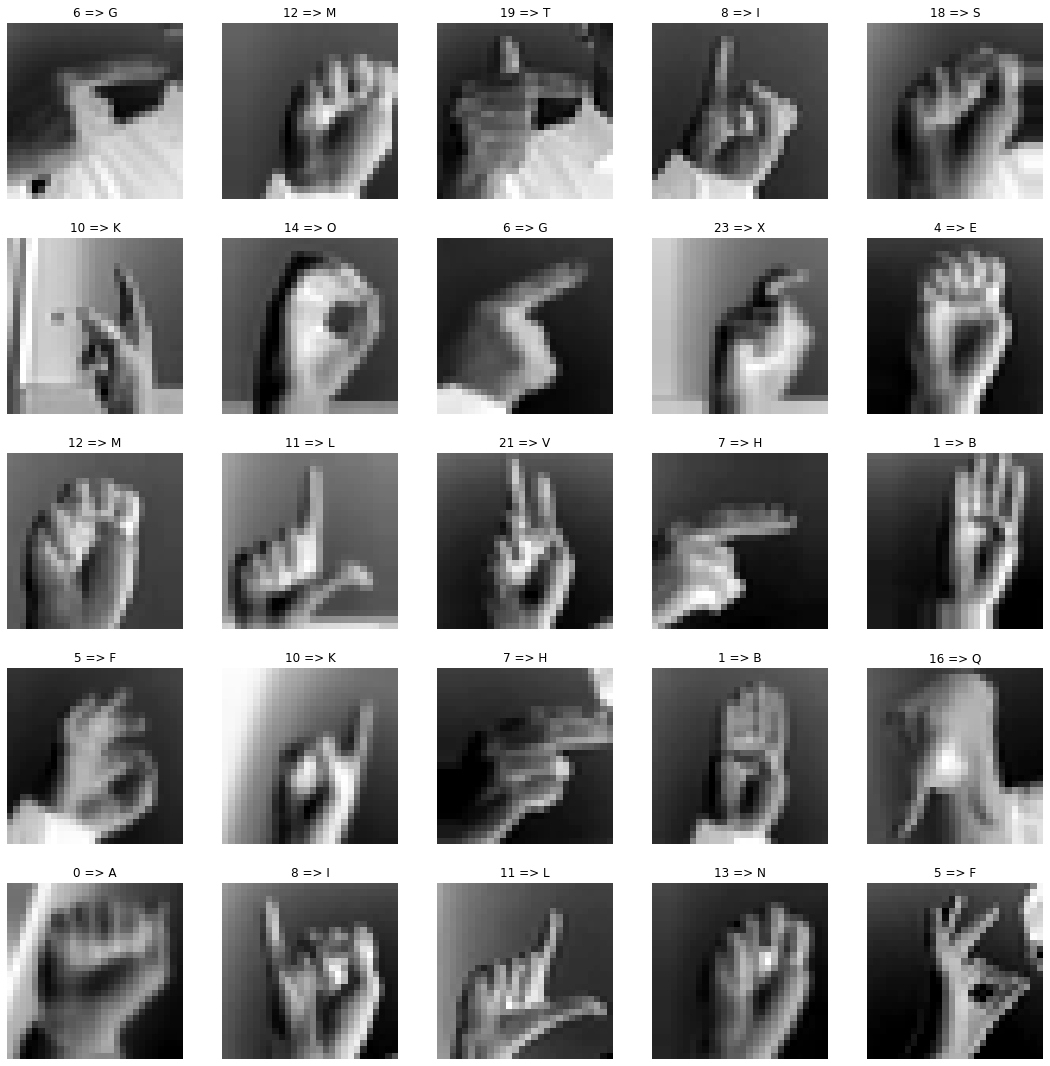

In [15]:
figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0
contc = 0
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(X_train_val_sf[i], cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(y_train_val_sf[i], sig_labels[y_train_val_sf[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

##### I will rescale the pixel values from the range [0, 255] to [0, 1]. Additionally, since I will be uploading a convolutional neural network for image classification, I need to modify the structure of the samples: each sample must be represented as a 28x28 matrix (which is already done since it was necessary to use that structure for image augmentation).

##### Voy a reducir el rango de los valores de los píxeles desde [0, 255] hasta [0, 1]. Además, como voy a subir una red neuronal convolucional para clasificar imágenes, tengo que cambiar la estructura de las muestras: cada muestra ha de estar representada mediante una matriz de 28x28 (lo cual está hecho ya, debido a que era necesario utilizar esa estructura para la extensión de las imágenes).

In [16]:
X_train = X_train_val_sf[0 : 75000].copy() / 255.0
y_train = y_train_val_sf[0 : 75000].copy()

X_val = X_train_val_sf[75000 : ].copy() / 255.0
y_val = y_train_val_sf[75000 :].copy()

In [17]:
X_train.shape, X_val.shape

((75000, 28, 28, 1), (7365, 28, 28, 1))

## Now I will create and train the network

## Ahora voy a crear y a entrenar la red

In [18]:
CNN = Sequential([

    Conv2D(filters = 64, kernel_size = 7,
           kernel_initializer = "he_uniform", padding = "same",
           input_shape = (28, 28, 1), strides = 1),
    
    BatchNormalization(),
    
    Activation("relu"),
    
    MaxPooling2D(pool_size = 2, padding = "same"), 
    # By not specifying strides, it will use the same value as the pool_size, which is 2 in this case.
    # al no poner strides usará el mismo que el pool_size, 2 en este caso
    
    Conv2D(filters = 128, kernel_size = 3,
           kernel_initializer = "he_uniform", padding = "same",
           strides = 1),
    
    BatchNormalization(),
    
    Activation("relu"),
    
    MaxPooling2D(pool_size = 2, padding = "same"),
    
    Conv2D(filters = 256, kernel_size = 3,
           kernel_initializer = "he_uniform", padding = "same",
           strides = 1),
    
    BatchNormalization(),
    
    Activation("relu"),
    
    MaxPooling2D(pool_size = 2, padding = "same"),

    #----------------------------------

    Flatten(),
    
    Dense(units = 240, activation = "relu",
          kernel_initializer = "he_uniform"),
    
    Dropout(0.5),
    
    Dense(units = 240, activation = "relu",
          kernel_initializer = "he_uniform"),
    
    Dropout(0.5),
    
    Dense(units = 25, activation = "softmax",
          kernel_initializer = "glorot_uniform")   
    
])

In [19]:
CNN.compile(optimizer = "nadam",
               loss = "sparse_categorical_crossentropy",
               metrics = ["accuracy"])

In [20]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("Modelos/CNN.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

In [21]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0

In [22]:
history_CNN = CNN.fit(X_train, y_train, epochs = 100,
                      validation_data = (X_val, y_val),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
2344/2344 [==============================] - 1575s 672ms/step - loss: 3.0584 - accuracy: 0.0772 - val_loss: 2.7247 - val_accuracy: 0.1602
Epoch 2/100
2344/2344 [==============================] - 1346s 574ms/step - loss: 2.6369 - accuracy: 0.1500 - val_loss: 2.3273 - val_accuracy: 0.2119
Epoch 3/100
2344/2344 [==============================] - 1543s 658ms/step - loss: 2.3048 - accuracy: 0.2376 - val_loss: 1.9738 - val_accuracy: 0.3542
Epoch 4/100
2344/2344 [==============================] - 1973s 842ms/step - loss: 1.9122 - accuracy: 0.3635 - val_loss: 1.7244 - val_accuracy: 0.3889
Epoch 5/100
2344/2344 [==============================] - 1987s 848ms/step - loss: 1.2748 - accuracy: 0.5567 - val_loss: 1.1111 - val_accuracy: 0.5859
Epoch 6/100
2344/2344 [==============================] - 1978s 844ms/step - loss: 0.9334 - accuracy: 0.6636 - val_loss: 0.7406 - val_accuracy: 0.6974
Epoch 7/100
2344/2344 [==============================] - 1662s 709ms/step - loss: 0.6682 - accuracy:

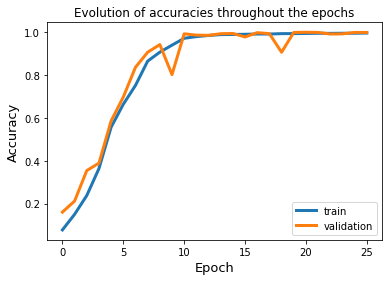

<Figure size 1080x648 with 0 Axes>

In [23]:
plt.plot(history_CNN.history['accuracy'], linewidth = 3)
plt.plot(history_CNN.history['val_accuracy'], linewidth = 3)
#plt.plot(history_CNN.history['loss'], linewidth = 1)
#plt.plot(history_CNN.history['val_loss'], linewidth = 1)
plt.title('Evolution of accuracies throughout the epochs')
plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('Epoch', fontsize = 13)
plt.legend(['train', 'validation'], loc='lower right')
plt.figure(figsize=(15,9))
plt.show()

### Now I am going to evaluate the network using the training and validation sets.

### Ahora voy a evaluar la red mediante los conjuntos de entrenamiento y validación:

In [24]:
CNN.evaluate(X_train, y_train), CNN.evaluate(X_val, y_val)

231/231 [==============================] - 40s 173ms/step - loss: 6.8419e-04 - accuracy: 0.9999


([0.0007369163213297725, 0.9997866749763489],
 [0.0006841908907517791, 0.9998642206192017])

### The results obtained in both sets have been incredibly good, achieving 99.98% accuracy on the training set and 99.99% accuracy on the validation set. 
### Now I will evaluate the model on the test set:

### Los resultados obtenidos en ambos conjuntos han sido increblemente buenos, obteniendo una precisión del 99.98% en el conjunto de entrenamiento y una precisión del 99.99% en el conjunto de validación.
### Ahora evaluaré el modelo en el conjunto de prueba:

In [25]:
test_set = pd.read_csv("../Datos/sign_mnist_test.csv")

test_y_df = test_set["label"]
test_X_df = test_set.drop("label", axis = "columns")

test_y = test_y_df.to_numpy()
test_X = test_X_df.to_numpy()

In [26]:
test_X.shape, test_y.shape

((7172, 784), (7172,))

In [27]:
X_test = test_X.copy().reshape(7172, 28, 28, 1) / 255.0
y_test = test_y.copy()

In [28]:
X_test.shape, y_test.shape

((7172, 28, 28, 1), (7172,))

In [29]:
CNN.evaluate(X_test, y_test)

225/225 [==============================] - 38s 170ms/step - loss: 0.0026 - accuracy: 0.9994


[0.002562415786087513, 0.9994422793388367]

## The accuracy of the network on the test set is 99.94%!!
## The network correctly predicted 7168 samples out of the 7172 samples in the test set, misspredicting only 4 samples.

## ¡¡La precisión de la red en el conjunto de prueba es del 99.94%!!
## La red ha predicho correctamente 7168 muestras de las 7172 que contiene el conjunto de prueba, por lo que solo ha predicho incorrectamente 4 muestras.

## I will draw the confusion matrix to analyze the errors made by the network.

## Voy a dibujar la matriz de confusión analizando los errores cometidos por la red.

In [30]:
pred_CNN = np.argmax(CNN.predict(X_test), axis = 1)

In [31]:
conf_mx = confusion_matrix(y_test, pred_CNN)

In [32]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


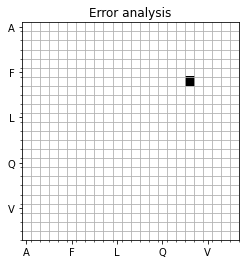

<Figure size 1440x1440 with 0 Axes>

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
minor_tick = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
              11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
              20.5, 21.5, 22.5, 23.5, 24.5]
ax.set_xticks(minor_tick, minor=True)
ax.set_yticks(minor_tick, minor=True)
ax.imshow(norm_conf_mx, cmap = plt.cm.gray.reversed())

labels = list("AAFLQV")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.grid(which='minor', alpha=1)

plt.title("Error analysis")
plt.figure(figsize = (20, 20))
plt.show()

## The network has made the same error four times: predicting the letter T with samples related to the symbol G.

## La red ha cometido el mismo error 4 veces: predecir la letra T con muestras referentes al símbolo G.

### I will save the created model:

### Voy a guardar el modelo creado:

In [34]:
CNN.save("Modelos/CNN_definitive.h5")

## CONCLUSION:

### The obtained network has achieved accuracies of 99.98% and 99.99% on the training and validation sets, respectively, which were used for fine-tuning the model. The ultimate test of validity was conducted on the test set, resulting in an accuracy of 99.94% (4 errors out of a total of 7172 samples). Thus, the created deep convolutional neural network has surpassed the addressed task with incredible success, demonstrating its ability to generalize with great precision to a wide variety of samples.

## CONCLUSIÓN:

### La red obtenida ha conseguido unas precisiones del 99.98% y 99.99% en los conjuntos de entrenamiento y validación, respectivamente, los cuales han sido utilizados para la puesta a punto del modelo. La prueba definitiva de validez se ha realizado mediante el conjunto de prueba, logrando una precisión del 99.94% (4 errores sobre un total de 7172 muestras). De esta forma, la red neuronal convolucional profunda creada ha superado la tarea abordada con increíble éxito, demostrando que es capaz de generalizar con gran precisión a una gran variedad de muestras.